In this notebook, we make explicit the relationship between the clusters and the time of creation as well as their relationship.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as scp
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import slingshot
import scipy.stats as st

from parameters import *

import sys
sys.path.append('../')
import single_cell_tools.tools as scttools
import single_cell_tools.plot as sctplot
import single_cell_tools.hyperparameter_selection as scthyp

# Global

In [2]:
adata = scp.read(DIRECTORY+"Results/QC.h5ad")

## UMAP with time projections

We mark explicitely the cells over the umap at the times they were generated.

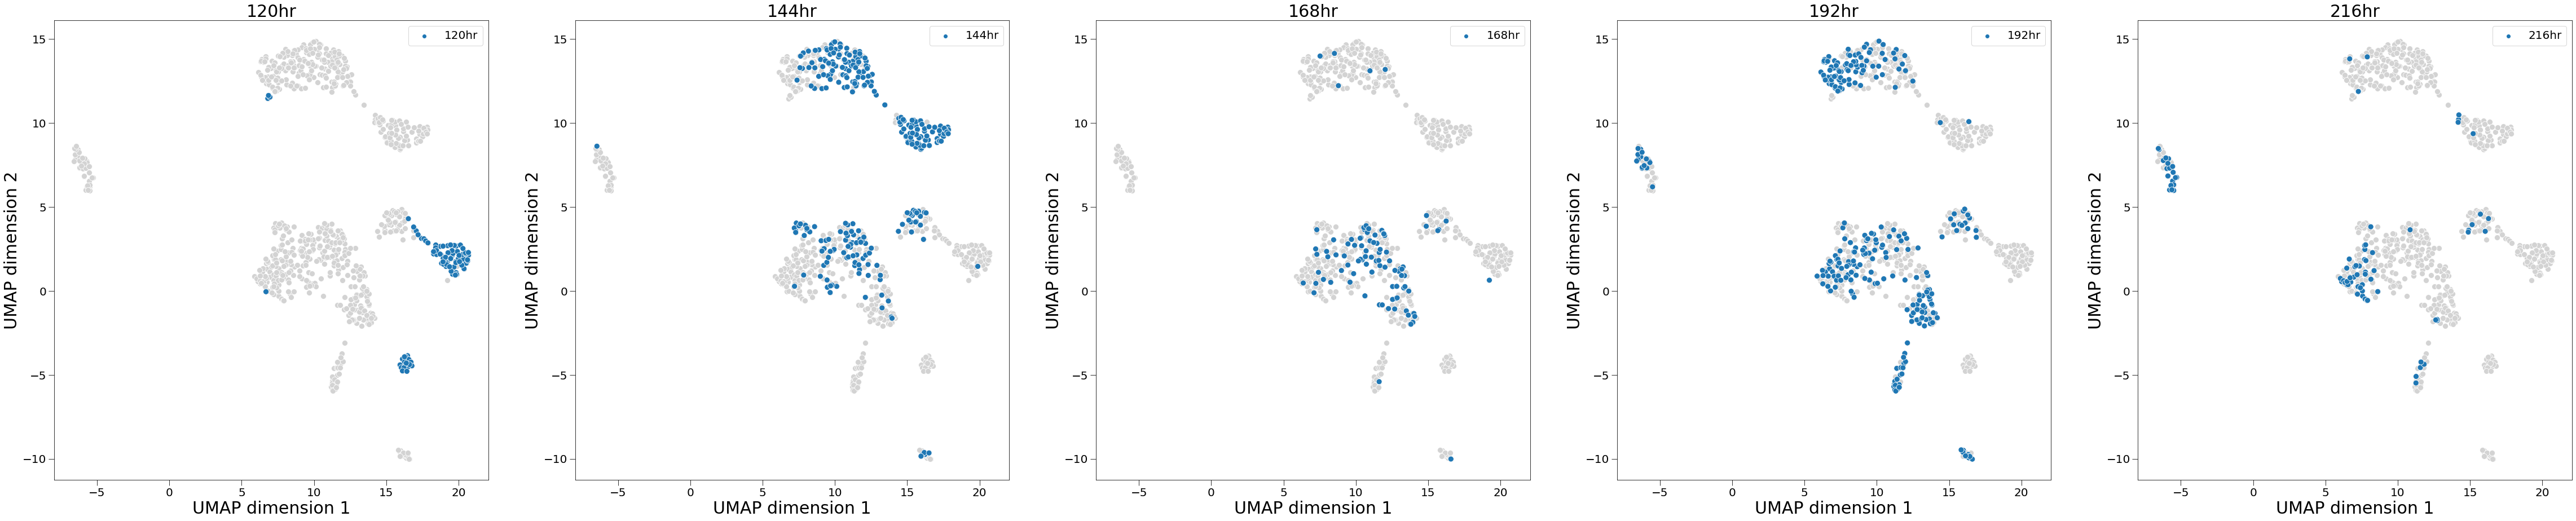

In [3]:
fig,ax = plt.subplots(1,5,figsize=[80,15])

for j,i in enumerate(np.sort(adata.obs["Time"].unique())):
    sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],s=100,color="lightgrey",ax=ax[j])
    sns.scatterplot(x=adata[adata.obs["Time"]==i].obsm["X_umap"][:,0],
                    y=adata[adata.obs["Time"]==i].obsm["X_umap"][:,1],
                    hue=adata[adata.obs["Time"]==i].obs["Time"],s=100,ax=ax[j])
    sctplot.plot_base(ax[j],title=i,labels=["UMAP dimension 1","UMAP dimension 2"])
    
fig.savefig(DIRECTORY+"Plots/Global/TR_UMAP_by_times.pdf",bbox_inches="tight",transparent=True)

## Paga

We connect the clusters using the PAGA algorithm and show the time contribution to each clusters in a pie plot overlayed over the UMAP plot.

### All times

In [4]:
scp.pp.neighbors(adata,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
scp.tl.paga(adata,groups="leiden")

2022-08-01 10:26:40.602435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-01 10:26:40.602449: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
def plot_scatter_lines(ax,adata,obsm,obs,matrix,width=10):

    categories = adata.obs[obs]
    for i,origin in enumerate(categories.cat.categories.values): 
        for j,target in enumerate(categories.cat.categories.values):
            x1,y1=adata[categories==origin].obsm[obsm].mean(axis=0)
            x2,y2=adata[categories==target].obsm[obsm].mean(axis=0)
            
            ax.plot([x1,x2],[y1,y2],linewidth=width*matrix[i,j],color="black")

    return

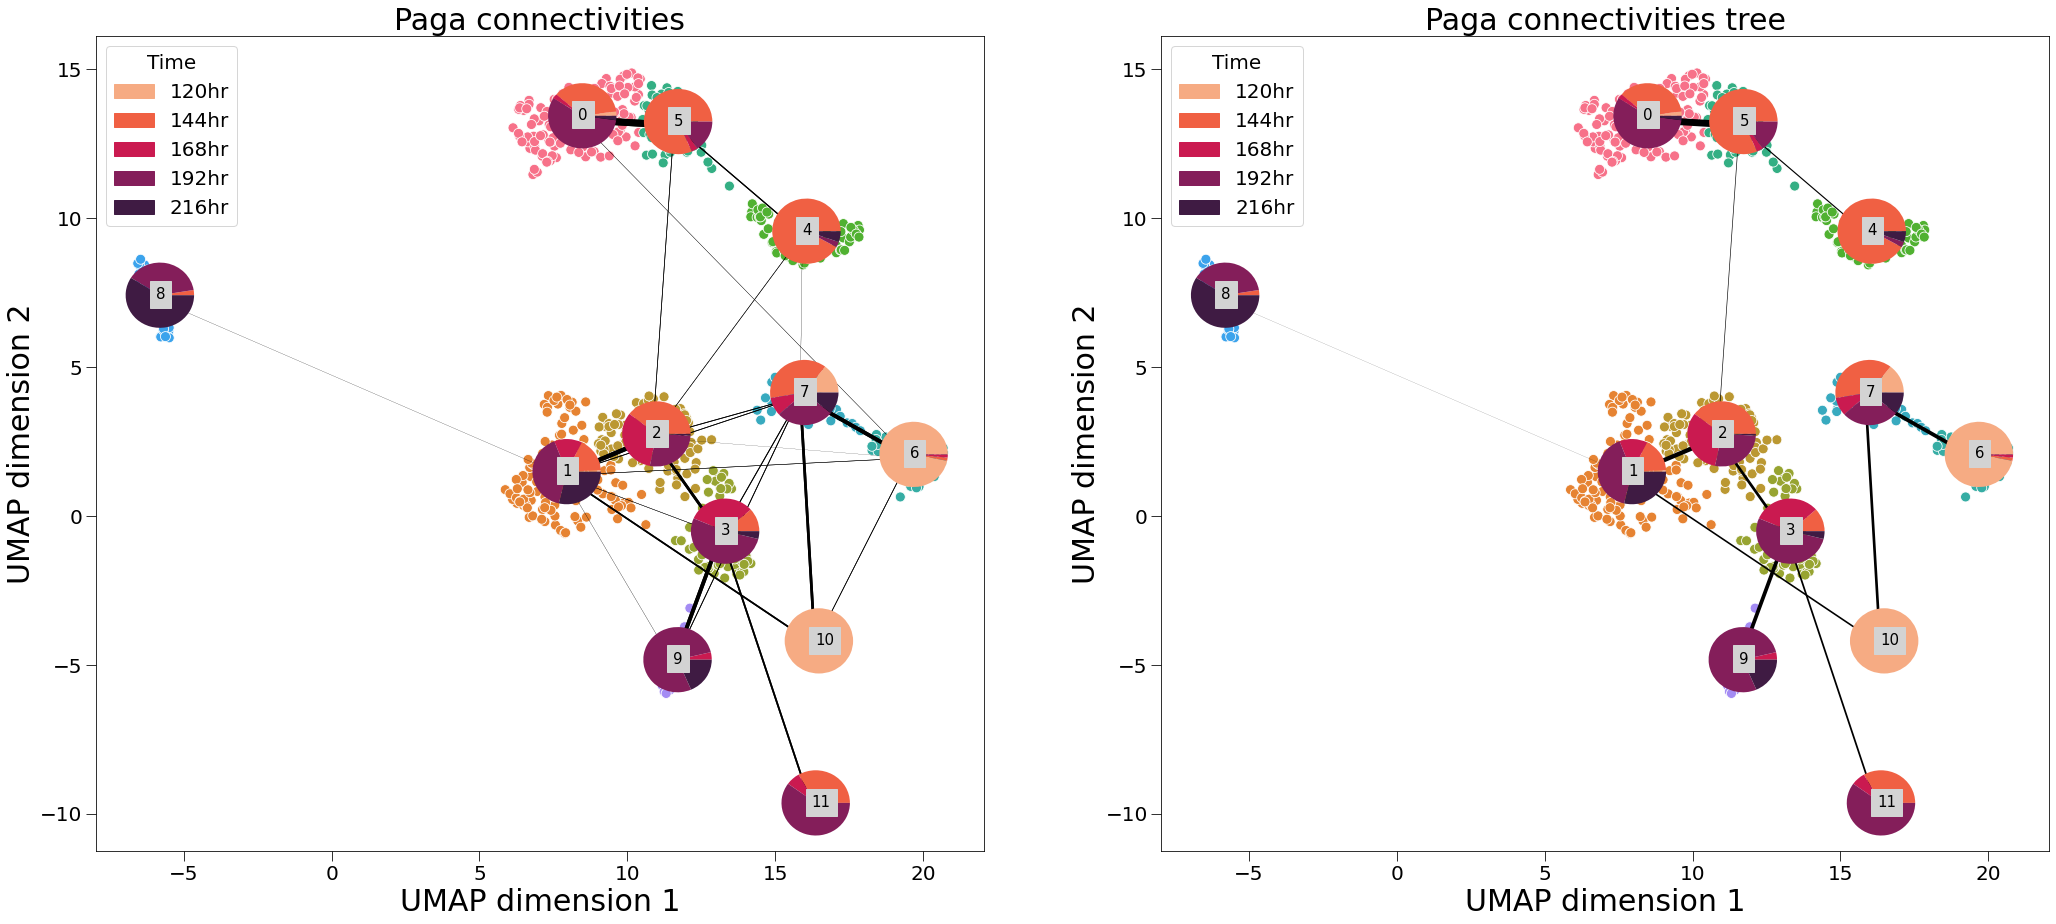

In [6]:
fig,ax = plt.subplots(1,2,figsize=[35,15])

# Plots
weight = adata.uns["paga"]["connectivities"].todense()
sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],hue=adata.obs["leiden"],s=100,ax=ax[0])
sctplot.plot_scatter_lines(ax[0],adata,"X_umap","leiden",weight)
sctplot.plot_base(ax[0],title="Paga connectivities",labels=["UMAP dimension 1","UMAP dimension 2"])
sctplot.plot_scatter_pies(ax[0],adata,"X_umap","leiden","Time")
sctplot.plot_scatter_labels(ax[0],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)

# Plots
weight = adata.uns["paga"]["connectivities_tree"].todense()
sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],hue=adata.obs["leiden"],s=100,ax=ax[1])
sctplot.plot_scatter_lines(ax[1],adata,"X_umap","leiden",weight)
sctplot.plot_base(ax[1],title="Paga connectivities tree",labels=["UMAP dimension 1","UMAP dimension 2"])
sctplot.plot_scatter_pies(ax[1],adata,"X_umap","leiden","Time")
sctplot.plot_scatter_labels(ax[1],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)

fig.savefig(DIRECTORY+"Plots/Global/TR_Paga_UMAP.pdf",bbox_inches="tight",transparent=True)

In [7]:
paga_robustness = np.zeros_like(adata.uns["paga"]["connectivities"].todense())

for i in range(N_DOWNSAMPLE):
    adataDownsample = scttools.downsample(adata,P_DOWNSAMPLE,batch="leiden",seed=i).copy()
    scp.pp.neighbors(adataDownsample,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
    scp.tl.paga(adataDownsample,groups="leiden")
    paga_robustness += adataDownsample.uns["paga"]["connectivities"].todense() > 0
            
paga_robustness /= N_DOWNSAMPLE

#Redo paga just in case
scp.pp.neighbors(adata,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
scp.tl.paga(adata,groups="leiden")

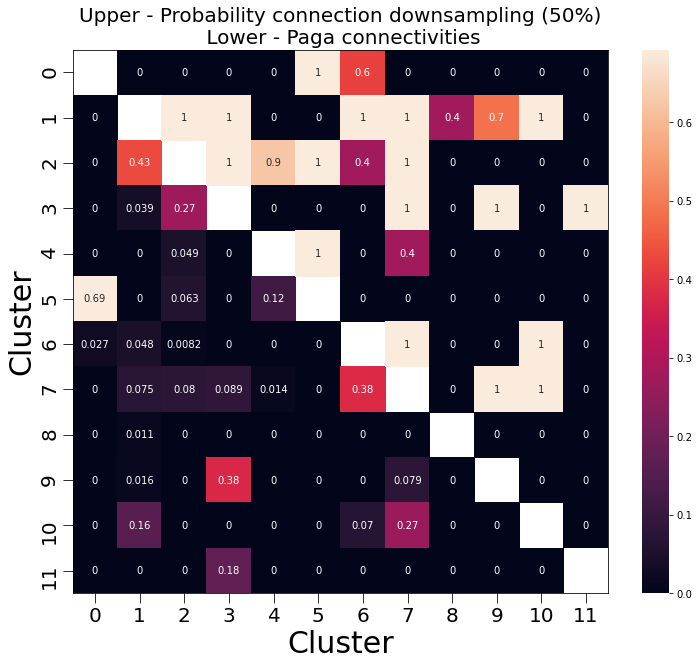

In [8]:
fig,ax = plt.subplots(1,1,figsize=[12,10])

paga = adata.uns["paga"]["connectivities"].todense()
mask = np.zeros_like(paga)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(paga,annot=True,mask=mask,ax=ax)

mask = np.zeros_like(paga)
mask[np.tril_indices_from(mask)] = True
paga_robustness[paga == 0] = 0
sns.heatmap(paga_robustness,annot=True,mask=mask,ax=ax,cbar=False)

sctplot.plot_base(ax,title="Upper - Probability connection downsampling (50%)\n Lower - Paga connectivities",title_size=20,labels=["Cluster","Cluster"]
                  ,xtick_labels=adata.obs["leiden"].cat.categories.values
                  ,ytick_labels=adata.obs["leiden"].cat.categories.values,
                 legend=False)

fig.savefig(DIRECTORY+"Plots/Global/TR_Paga_heatmap.pdf",bbox_inches="tight",transparent=True)

### Connection by times

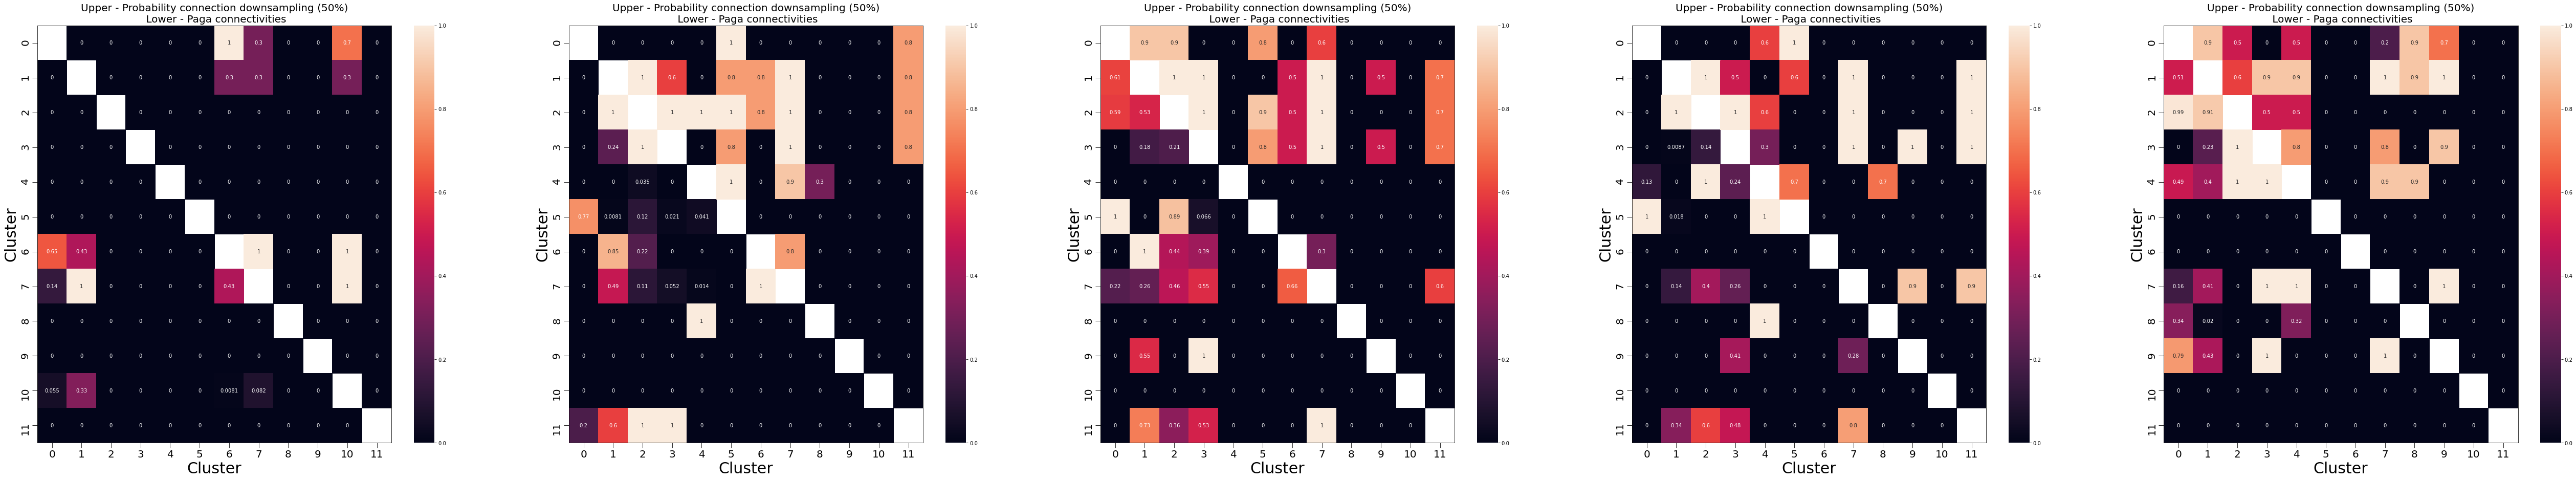

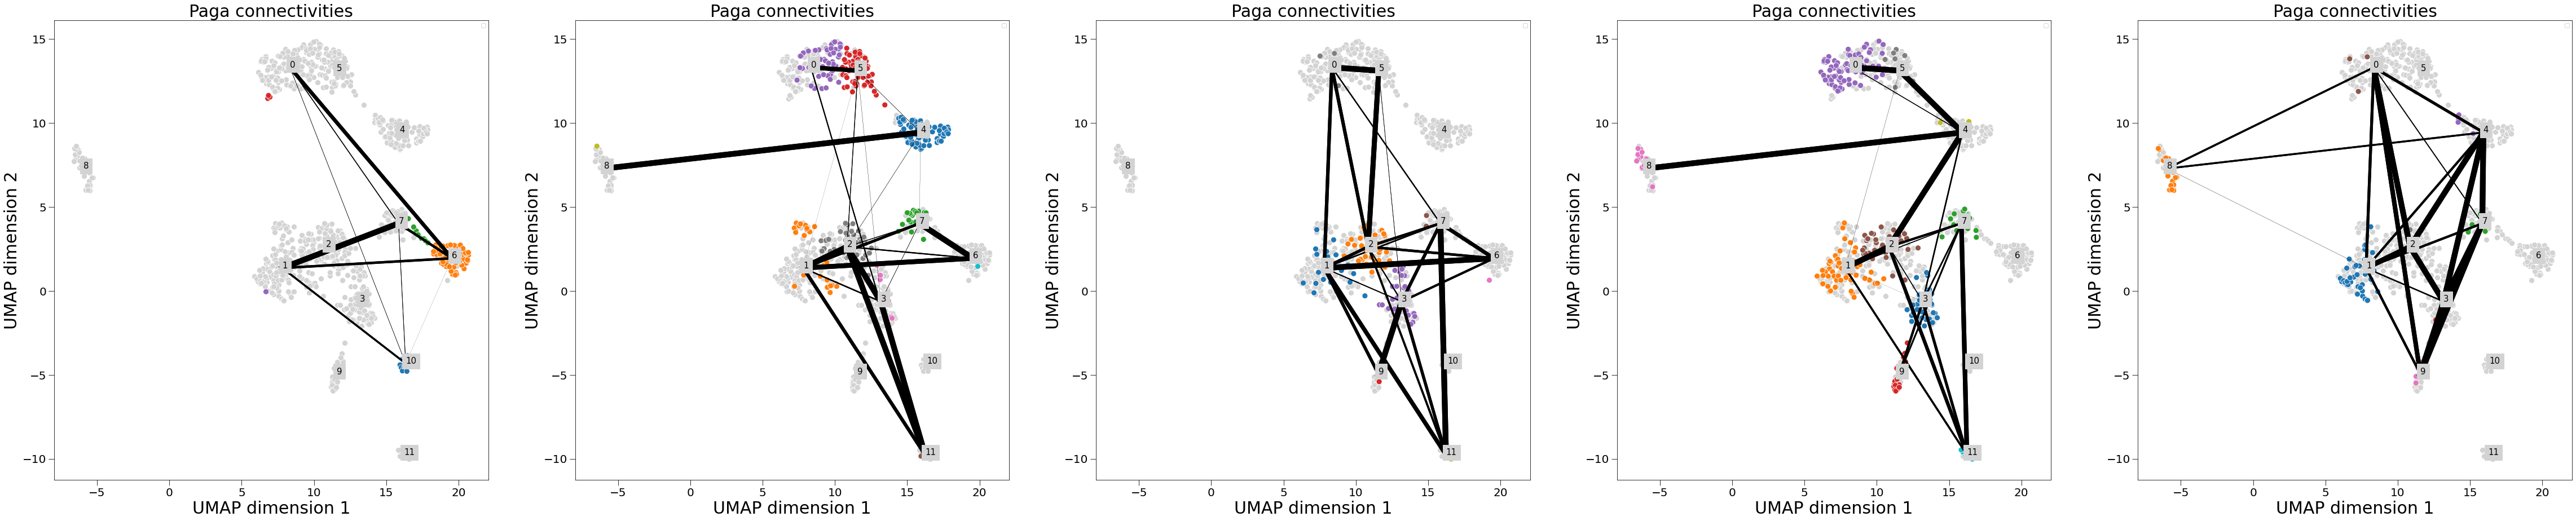

In [9]:
fig,ax = plt.subplots(1,5,figsize=[90,15])
fig2,ax2 = plt.subplots(1,5,figsize=[80,15])

map_cluster2pos = {j:i for i,j in enumerate(adata.obs["leiden"].cat.categories.values)}
cpalette = sns.color_palette("husl",len(adata.obs["leiden"].unique()))
for t,time in enumerate(np.unique(adata.obs["Time"])):
    
    adataSubset = adata[adata.obs["Time"] == time]

    scp.pp.neighbors(adataSubset,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
    scp.tl.paga(adataSubset,groups="leiden")

    paga = np.zeros([len(adata.obs["leiden"].unique()),len(adata.obs["leiden"].unique())])
    map_pos2pos = {k:map_cluster2pos[j] for k,j in enumerate(adataSubset.obs["leiden"].cat.categories.values)}
    m = adataSubset.uns["paga"]["connectivities"].todense()
    for j in range(m.shape[0]):
        for k in range(m.shape[1]):
            paga[map_pos2pos[j],map_pos2pos[k]] += m[j,k]
                
    paga_robustness = np.zeros([len(adata.obs["leiden"].unique()),len(adata.obs["leiden"].unique())])
    for i in range(N_DOWNSAMPLE):
        adataDownsample = scttools.downsample(adataSubset,P_DOWNSAMPLE,seed=i)
        map_pos2pos = {k:map_cluster2pos[j] for k,j in enumerate(adataDownsample.obs["leiden"].cat.categories.values)}
        scp.pp.neighbors(adataDownsample,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
        scp.tl.paga(adataDownsample,groups="leiden")
        m = adataDownsample.uns["paga"]["connectivities"].todense() > 0
        for j in range(m.shape[0]):
            for k in range(m.shape[1]):
                paga_robustness[map_pos2pos[j],map_pos2pos[k]] += m[j,k]
                
    paga_robustness /= N_DOWNSAMPLE
    
    #Redo paga just in case
    scp.pp.neighbors(adataSubset,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
    scp.tl.paga(adataSubset,groups="leiden")
    
    mask = np.zeros_like(paga)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(paga,annot=True,mask=mask,ax=ax[t])
    
    mask = np.zeros_like(paga)
    mask[np.tril_indices_from(mask)] = True
    paga_robustness[paga == 0] = 0
    sns.heatmap(paga_robustness,annot=True,mask=mask,ax=ax[t],cbar=False)
    
    sctplot.plot_base(ax[t],title="Upper - Probability connection downsampling (50%)\n Lower - Paga connectivities",title_size=20,labels=["Cluster","Cluster"]
                      ,xtick_labels=adata.obs["leiden"].cat.categories.values
                      ,ytick_labels=adata.obs["leiden"].cat.categories.values,
                     legend=False)
    
    # Scatterplots
    weight = adataSubset.uns["paga"]["connectivities"].todense()
    sns.scatterplot(x=adata[adata.obs["Time"]!=time].obsm["X_umap"][:,0],y=adata[adata.obs["Time"]!=time].obsm["X_umap"][:,1],s=100,color="lightgrey",ax=ax2[t])
    colors = [cpalette[int(i)] for i in adata[adata.obs["Time"]==time].obs["leiden"].values]
    sns.scatterplot(x=adata[adata.obs["Time"]==time].obsm["X_umap"][:,0],
                    y=adata[adata.obs["Time"]==time].obsm["X_umap"][:,1],
                    hue=colors,s=100,ax=ax2[t])
    sctplot.plot_scatter_lines(ax2[t],adata,"X_umap","leiden",paga)
    sctplot.plot_scatter_labels(ax2[t],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)
    sctplot.plot_base(ax2[t],title="Paga connectivities",labels=["UMAP dimension 1","UMAP dimension 2"],legend=False)
    ax2[t].legend([])
    
fig.savefig(DIRECTORY+"Plots/Global/TR_Paga_heatmap_times.pdf",bbox_inches="tight",transparent=True)
fig2.savefig(DIRECTORY+"Plots/Global/TR_Paga_UMAP_times.pdf",bbox_inches="tight",transparent=True)

## Slingshot

In [10]:
p = adata.obs.loc[:,"leiden"].astype(int).values
d = np.zeros([len(p),len(adata.obs["leiden"].cat.categories)])
for k in [[i,j] for i,j in enumerate(p)]:
    d[k[0],k[1]] = 1

In [11]:
m = adata.obsm["X_pca"][:,:PCA]

fig,ax = plt.subplots(2,2)

model = slingshot.Slingshot(m,d, start_node=0)
model.fit(num_epochs=1, debug_axes=ax);

plt.close(fig)

100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


In [12]:
m = adata.obsm["X_pca"][:,:PCA]
m = m.transpose()
m = m/np.sqrt(np.sum(m**2,axis=0))
m = m.transpose()

fig,ax = plt.subplots(2,2)

model2 = slingshot.Slingshot(m,d, start_node=0)
model2.fit(num_epochs=1, debug_axes=ax);

plt.close(fig)

100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


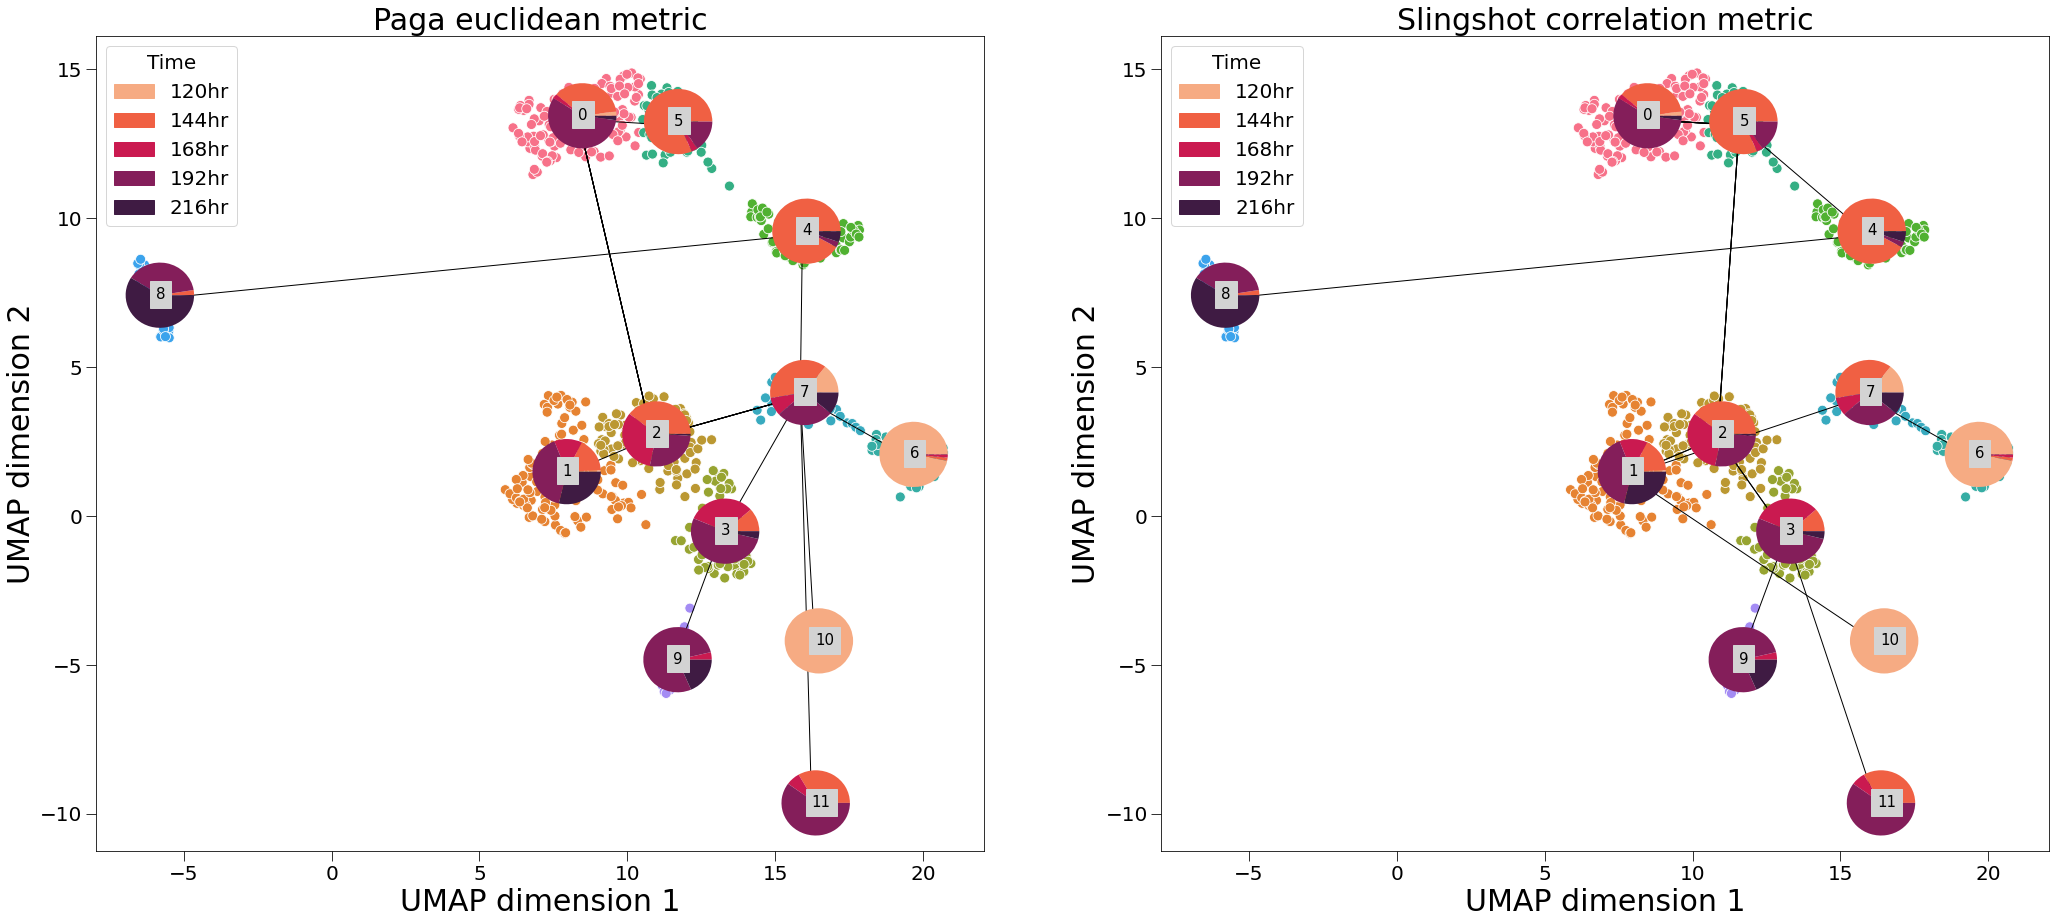

In [13]:
fig,ax = plt.subplots(1,2,figsize=[35,15])

# Plots
weight = adata.uns["paga"]["connectivities"].todense()
sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],hue=adata.obs["leiden"],s=100,ax=ax[0])
for lineage in model.lineages:
    for j in range(len(lineage.clusters)-1):
        x1,y1=adata[adata.obs["leiden"]==str(lineage.clusters[j])].obsm["X_umap"].mean(axis=0)
        x2,y2=adata[adata.obs["leiden"]==str(lineage.clusters[j+1])].obsm["X_umap"].mean(axis=0)
        
        ax[0].plot([x1,x2],[y1,y2],linewidth=1,color="black")
sctplot.plot_base(ax[0],title="Paga euclidean metric",labels=["UMAP dimension 1","UMAP dimension 2"])
sctplot.plot_scatter_pies(ax[0],adata,"X_umap","leiden","Time")
sctplot.plot_scatter_labels(ax[0],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)

# Plots
weight = adata.uns["paga"]["connectivities_tree"].todense()
sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],hue=adata.obs["leiden"],s=100,ax=ax[1])
for lineage in model2.lineages:
    for j in range(len(lineage.clusters)-1):
        x1,y1=adata[adata.obs["leiden"]==str(lineage.clusters[j])].obsm["X_umap"].mean(axis=0)
        x2,y2=adata[adata.obs["leiden"]==str(lineage.clusters[j+1])].obsm["X_umap"].mean(axis=0)
        
        ax[1].plot([x1,x2],[y1,y2],linewidth=1,color="black")
sctplot.plot_base(ax[1],title="Slingshot correlation metric",labels=["UMAP dimension 1","UMAP dimension 2"])
sctplot.plot_scatter_pies(ax[1],adata,"X_umap","leiden","Time")
sctplot.plot_scatter_labels(ax[1],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)

fig.savefig(DIRECTORY+"Plots/Global/TR_Slingshot_UMAP.pdf",bbox_inches="tight",transparent=True)

# Sorted

In [14]:
adata = scp.read(DIRECTORY+"Results/QC_sorted.h5ad")

## UMAP with time projections

We mark explicitely the cells over the umap at the times they were generated.

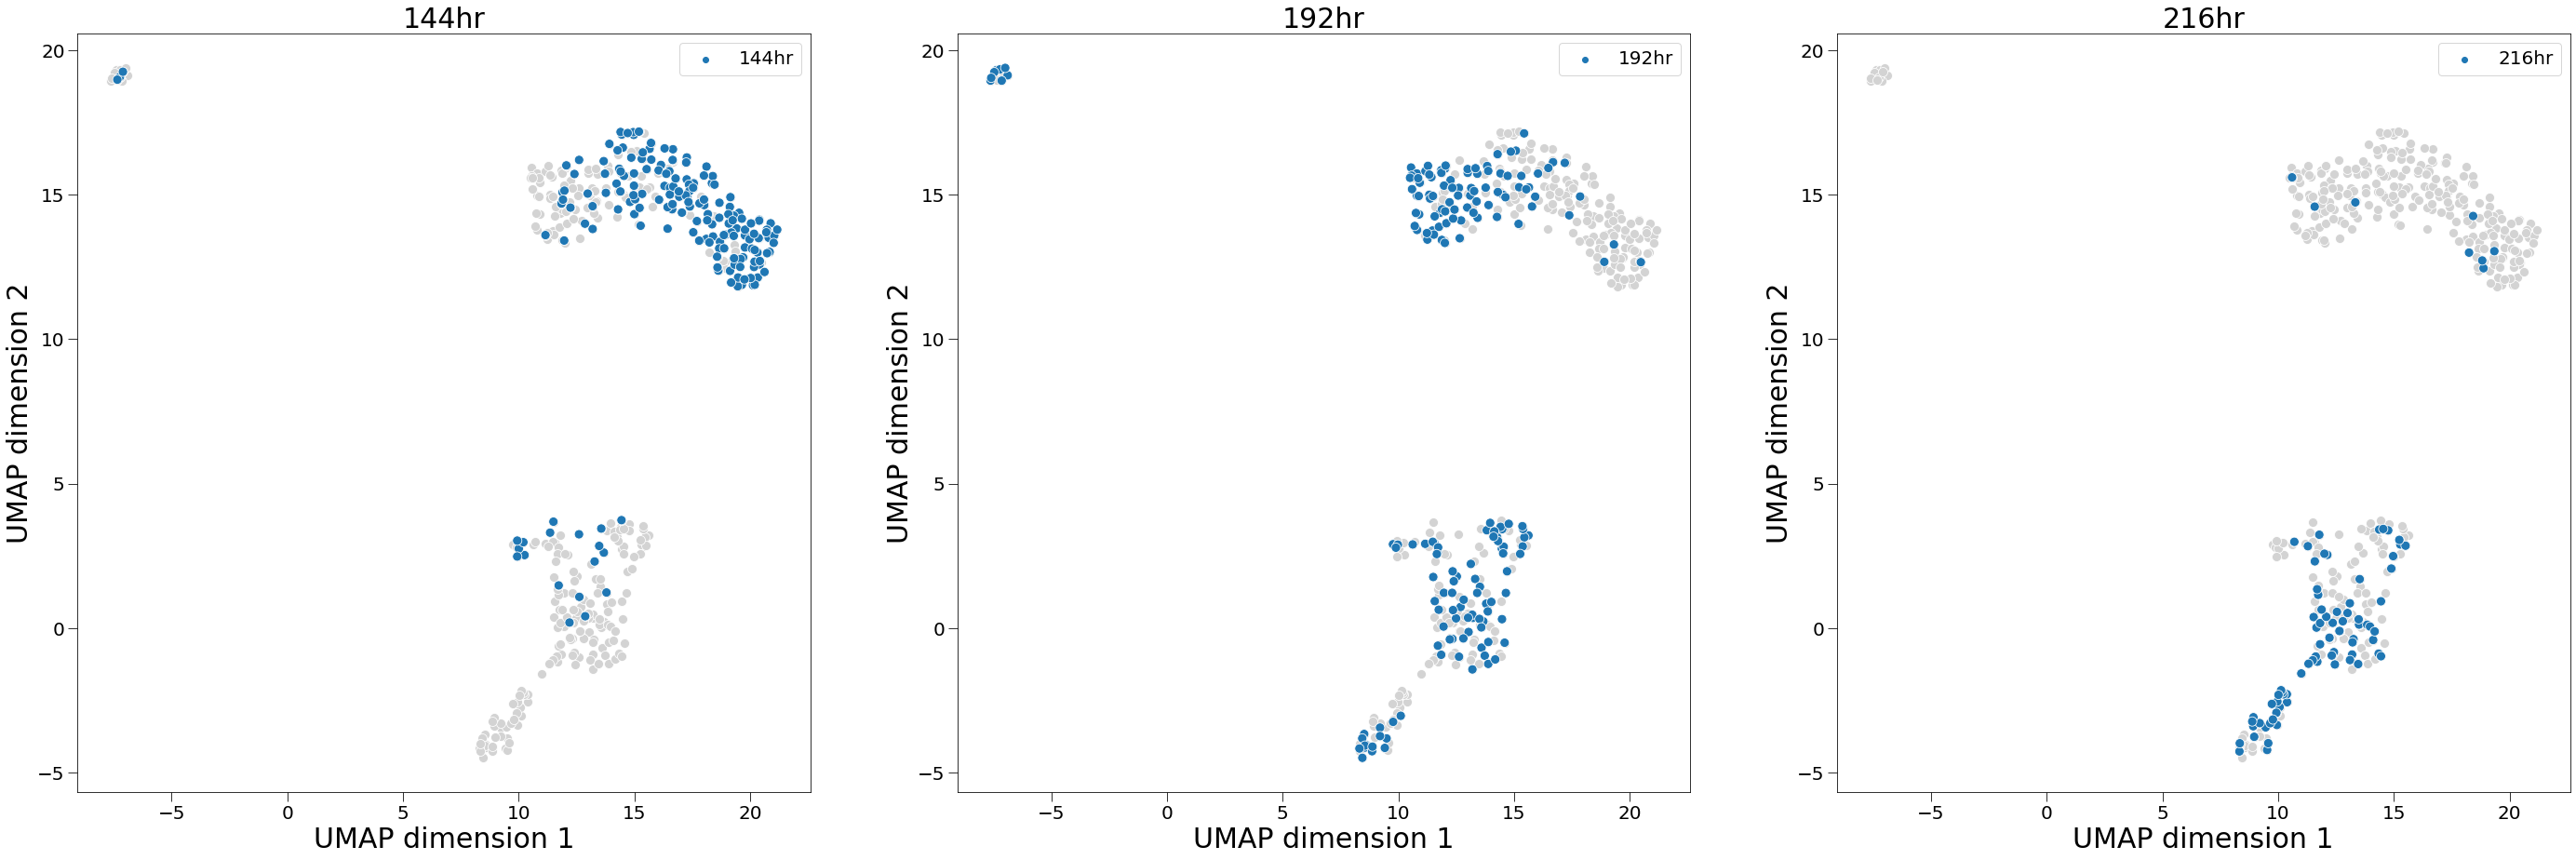

In [15]:
fig,ax = plt.subplots(1,3,figsize=[48,15])

for j,i in enumerate(np.sort(adata.obs["Time"].unique())):
    sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],s=100,color="lightgrey",ax=ax[j])
    sns.scatterplot(x=adata[adata.obs["Time"]==i].obsm["X_umap"][:,0],
                    y=adata[adata.obs["Time"]==i].obsm["X_umap"][:,1],
                    hue=adata[adata.obs["Time"]==i].obs["Time"],s=100,ax=ax[j])
    sctplot.plot_base(ax[j],title=i,labels=["UMAP dimension 1","UMAP dimension 2"])
    
fig.savefig(DIRECTORY+"Plots/Sorted/TR_UMAP_by_times.pdf",bbox_inches="tight",transparent=True)

## Paga

We connect the clusters using the PAGA algorithm and show the time contribution to each clusters in a pie plot overlayed over the UMAP plot.

### All times

In [16]:
scp.pp.neighbors(adata,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
scp.tl.paga(adata,groups="leiden")

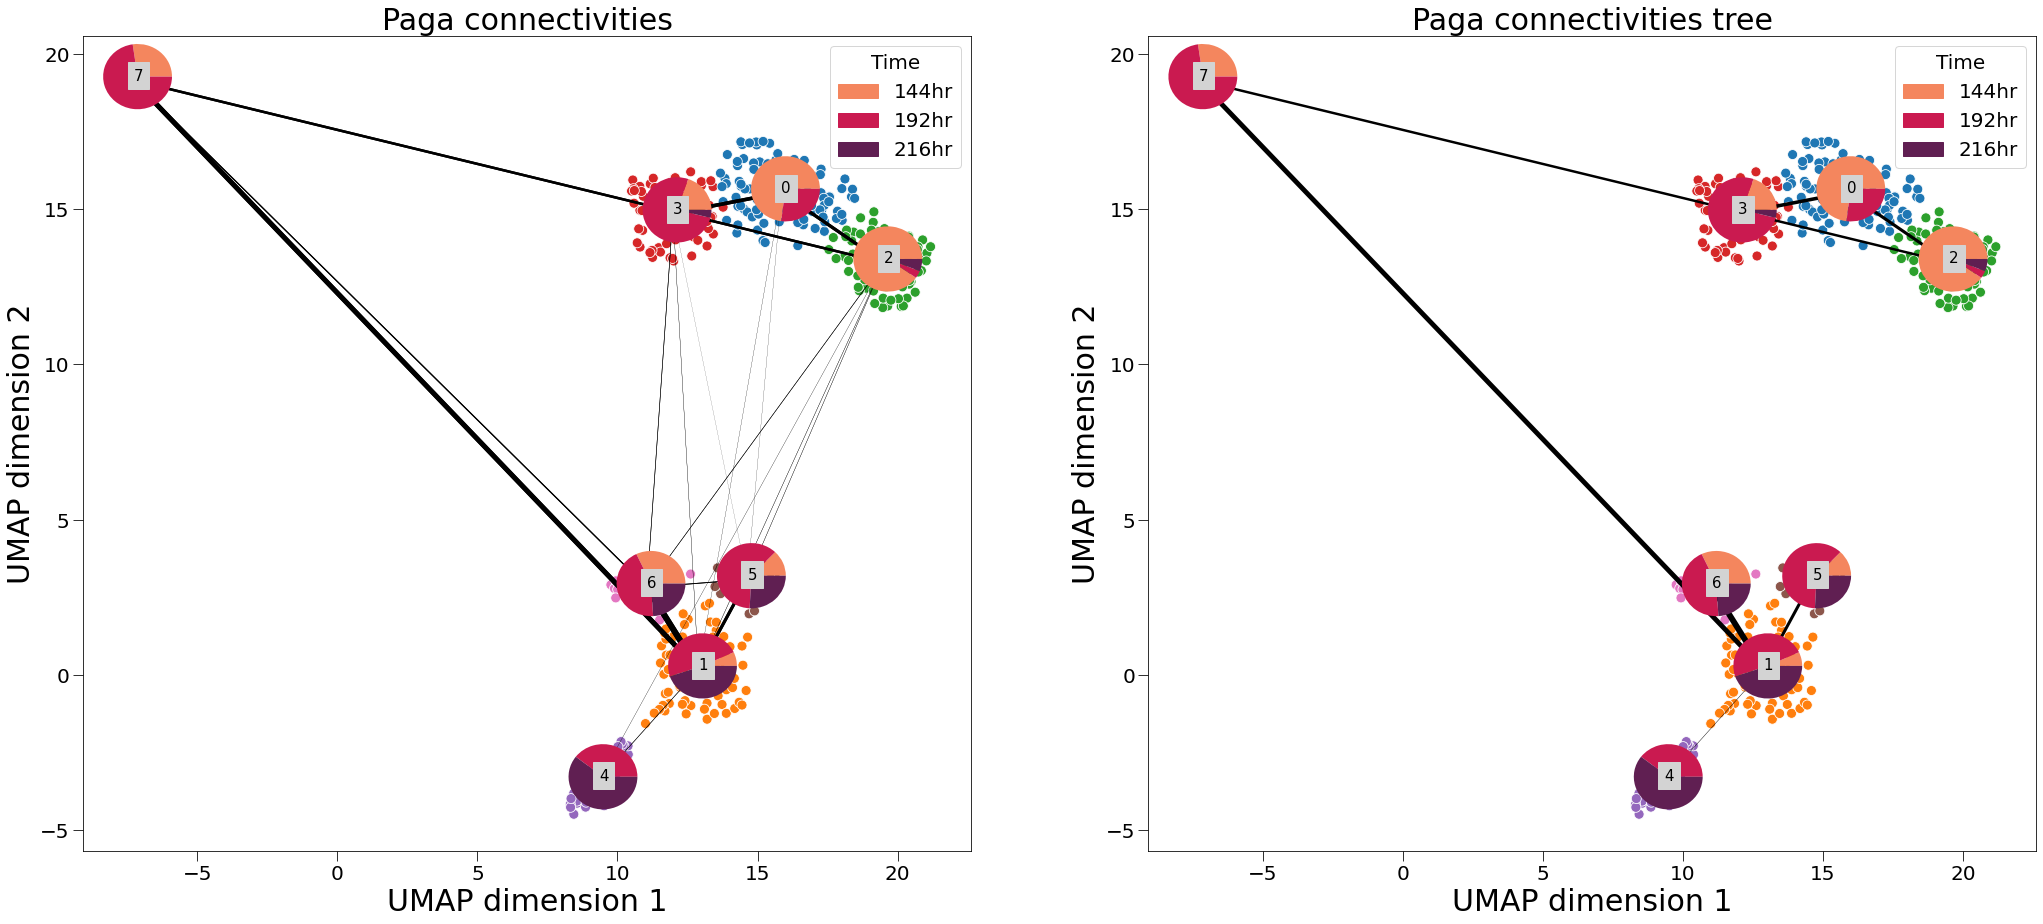

In [17]:
fig,ax = plt.subplots(1,2,figsize=[35,15])

# Plots
weight = adata.uns["paga"]["connectivities"].todense()
sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],hue=adata.obs["leiden"],s=100,ax=ax[0])
sctplot.plot_scatter_lines(ax[0],adata,"X_umap","leiden",weight)
sctplot.plot_base(ax[0],title="Paga connectivities",labels=["UMAP dimension 1","UMAP dimension 2"])
sctplot.plot_scatter_pies(ax[0],adata,"X_umap","leiden","Time")
sctplot.plot_scatter_labels(ax[0],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)

# Plots
weight = adata.uns["paga"]["connectivities_tree"].todense()
sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],hue=adata.obs["leiden"],s=100,ax=ax[1])
sctplot.plot_scatter_lines(ax[1],adata,"X_umap","leiden",weight)
sctplot.plot_base(ax[1],title="Paga connectivities tree",labels=["UMAP dimension 1","UMAP dimension 2"])
sctplot.plot_scatter_pies(ax[1],adata,"X_umap","leiden","Time")
sctplot.plot_scatter_labels(ax[1],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)

fig.savefig(DIRECTORY+"Plots/Sorted/TR_Paga_UMAP.pdf",bbox_inches="tight",transparent=True)

In [18]:
paga_robustness = np.zeros_like(adata.uns["paga"]["connectivities"].todense())

for i in range(N_DOWNSAMPLE):
    adataDownsample = scttools.downsample(adata,P_DOWNSAMPLE,batch="leiden",seed=i)
    scp.pp.neighbors(adataDownsample,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
    scp.tl.paga(adataDownsample,groups="leiden")
    paga_robustness += adataDownsample.uns["paga"]["connectivities"].todense() > 0
            
paga_robustness /= N_DOWNSAMPLE

#Redo paga just in case
scp.pp.neighbors(adata,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
scp.tl.paga(adata,groups="leiden")

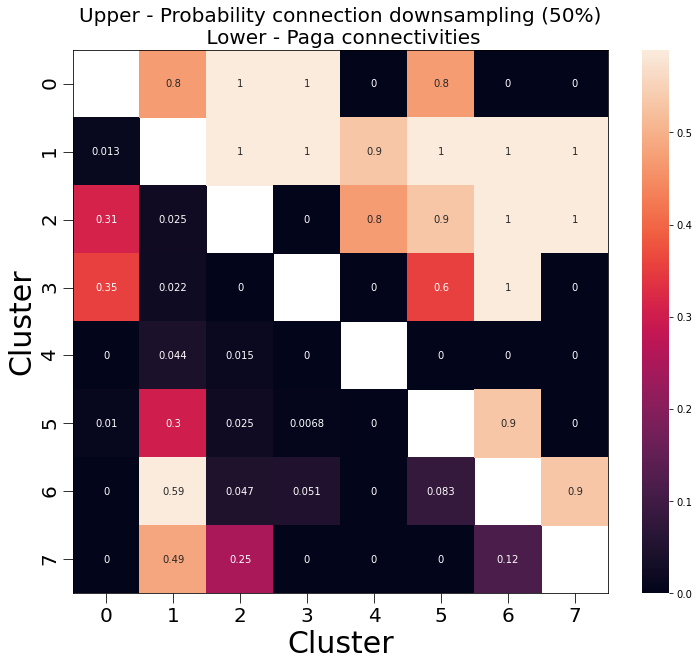

In [19]:
fig,ax = plt.subplots(1,1,figsize=[12,10])

paga = adata.uns["paga"]["connectivities"].todense()
mask = np.zeros_like(paga)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(paga,annot=True,mask=mask,ax=ax)

mask = np.zeros_like(paga)
mask[np.tril_indices_from(mask)] = True
paga_robustness[paga == 0] = 0
sns.heatmap(paga_robustness,annot=True,mask=mask,ax=ax,cbar=False)

sctplot.plot_base(ax,title="Upper - Probability connection downsampling (50%)\n Lower - Paga connectivities",title_size=20,labels=["Cluster","Cluster"]
                  ,xtick_labels=adata.obs["leiden"].cat.categories.values
                  ,ytick_labels=adata.obs["leiden"].cat.categories.values,
                 legend=False)

fig.savefig(DIRECTORY+"Plots/Sorted/TR_Paga_heatmap.pdf",bbox_inches="tight",transparent=True)

### Connection by times

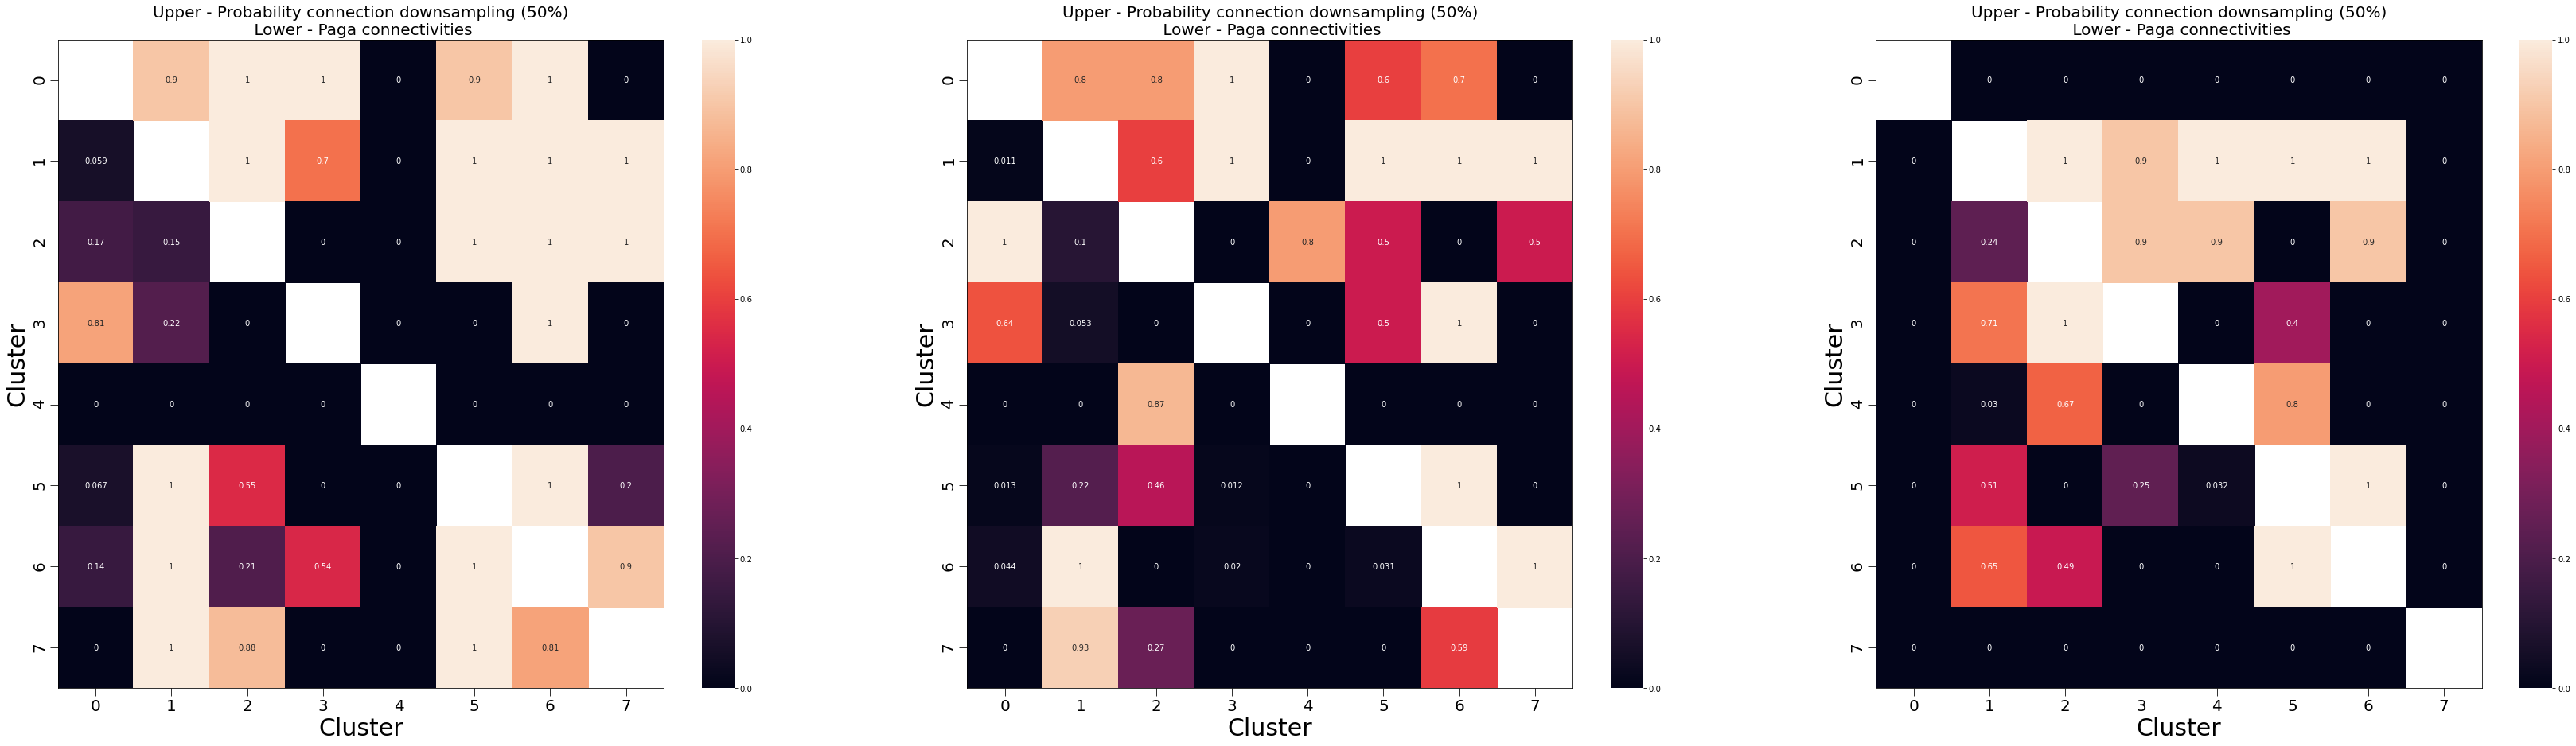

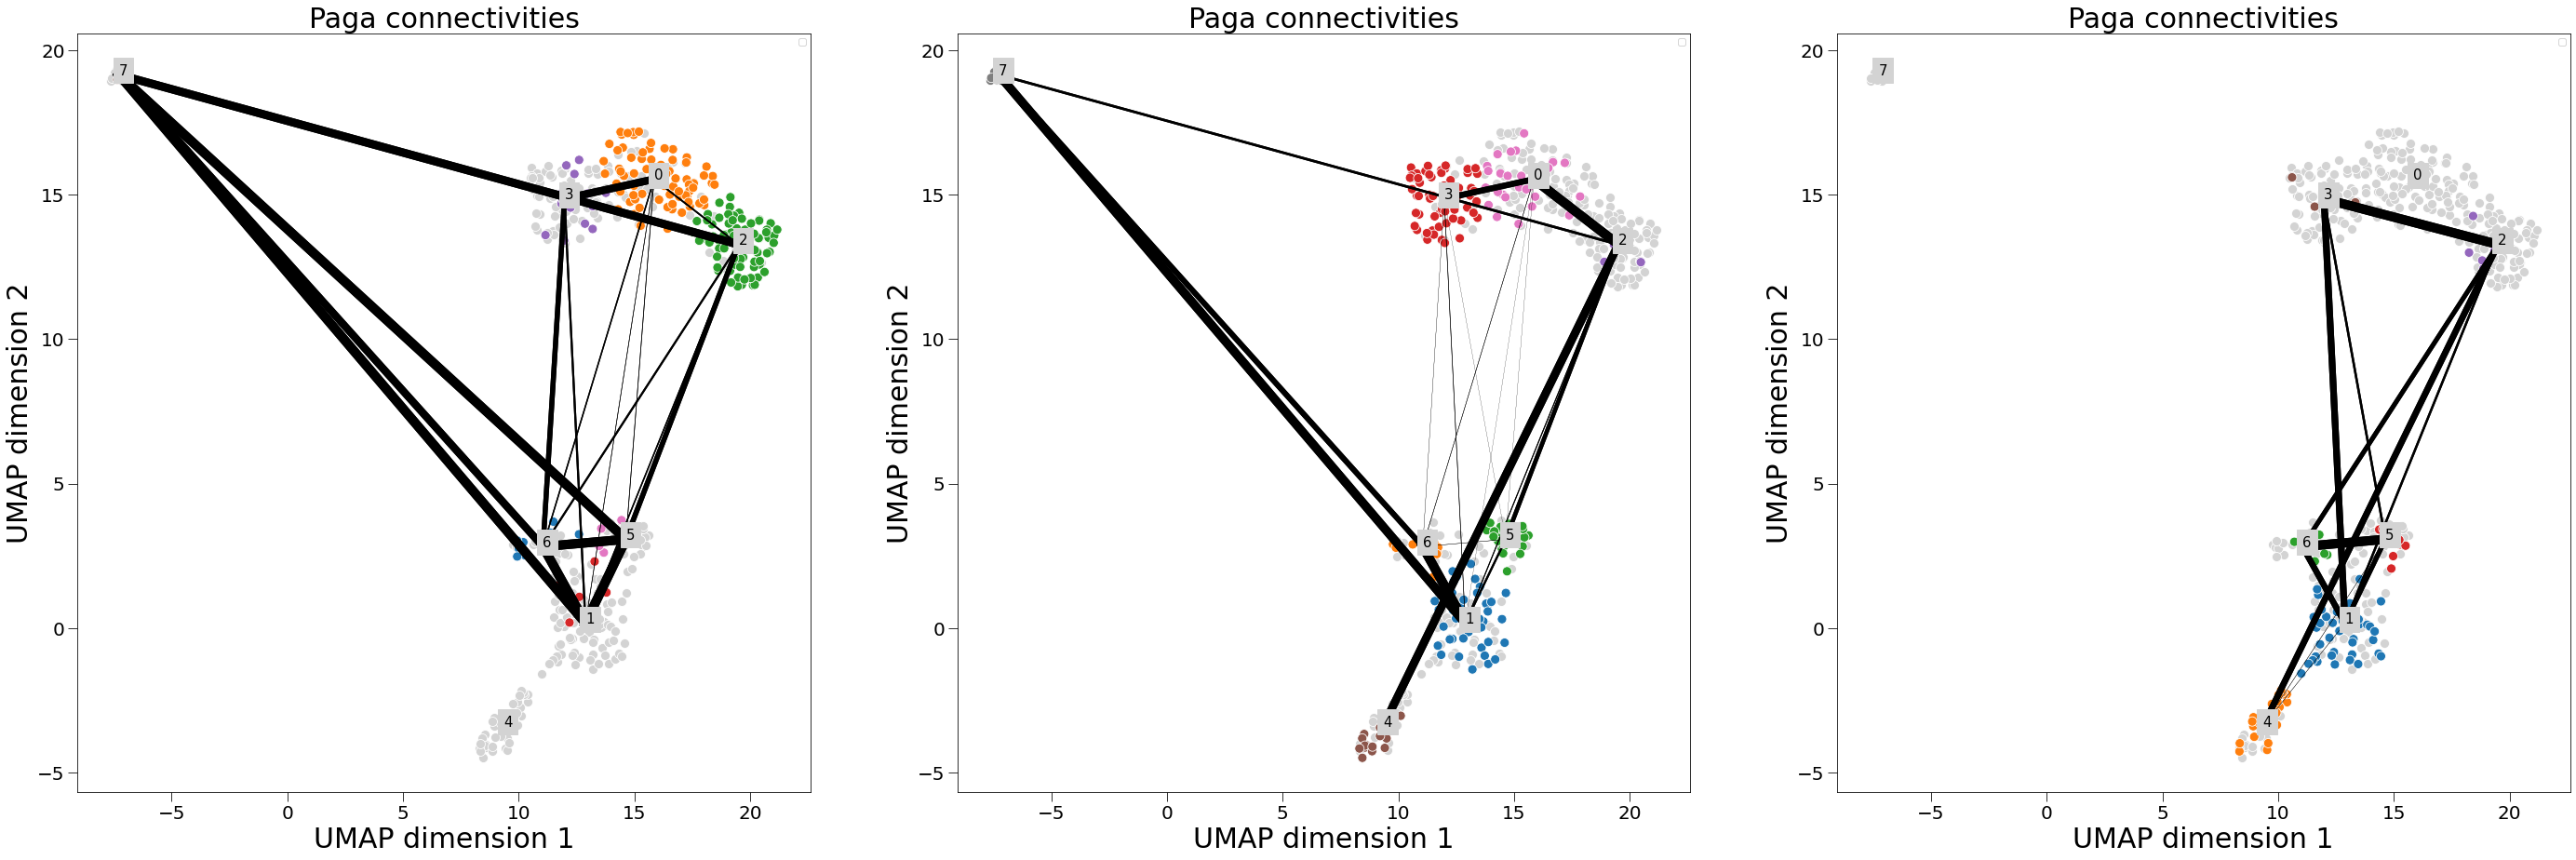

In [20]:
fig,ax = plt.subplots(1,3,figsize=[58,15])
fig2,ax2 = plt.subplots(1,3,figsize=[48,15])

map_cluster2pos = {j:i for i,j in enumerate(adata.obs["leiden"].cat.categories.values)}
cpalette = sns.color_palette("husl",len(adata.obs["leiden"].unique()))
for t,time in enumerate(np.unique(adata.obs["Time"])):
    
    adataSubset = adata[adata.obs["Time"] == time]

    scp.pp.neighbors(adataSubset,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
    scp.tl.paga(adataSubset,groups="leiden")

    paga = np.zeros([len(adata.obs["leiden"].unique()),len(adata.obs["leiden"].unique())])
    map_pos2pos = {k:map_cluster2pos[j] for k,j in enumerate(adataSubset.obs["leiden"].cat.categories.values)}
    m = adataSubset.uns["paga"]["connectivities"].todense()
    for j in range(m.shape[0]):
        for k in range(m.shape[1]):
            paga[map_pos2pos[j],map_pos2pos[k]] += m[j,k]
                
    paga_robustness = np.zeros([len(adata.obs["leiden"].unique()),len(adata.obs["leiden"].unique())])
    for i in range(N_DOWNSAMPLE):
        adataDownsample = scttools.downsample(adataSubset,P_DOWNSAMPLE,seed=i)
        map_pos2pos = {k:map_cluster2pos[j] for k,j in enumerate(adataDownsample.obs["leiden"].cat.categories.values)}
        scp.pp.neighbors(adataDownsample,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
        scp.tl.paga(adataDownsample,groups="leiden")
        m = adataDownsample.uns["paga"]["connectivities"].todense() > 0
        for j in range(m.shape[0]):
            for k in range(m.shape[1]):
                paga_robustness[map_pos2pos[j],map_pos2pos[k]] += m[j,k]
                
    paga_robustness /= N_DOWNSAMPLE
    
    #Redo paga just in case
    scp.pp.neighbors(adataSubset,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
    scp.tl.paga(adataSubset,groups="leiden")
    
    mask = np.zeros_like(paga)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(paga,annot=True,mask=mask,ax=ax[t])
    
    mask = np.zeros_like(paga)
    mask[np.tril_indices_from(mask)] = True
    paga_robustness[paga == 0] = 0
    sns.heatmap(paga_robustness,annot=True,mask=mask,ax=ax[t],cbar=False)
    
    sctplot.plot_base(ax[t],title="Upper - Probability connection downsampling (50%)\n Lower - Paga connectivities",title_size=20,labels=["Cluster","Cluster"]
                      ,xtick_labels=adata.obs["leiden"].cat.categories.values
                      ,ytick_labels=adata.obs["leiden"].cat.categories.values,
                     legend=False)
    
    # Scatterplots
    weight = adataSubset.uns["paga"]["connectivities"].todense()
    sns.scatterplot(x=adata[adata.obs["Time"]!=time].obsm["X_umap"][:,0],y=adata[adata.obs["Time"]!=time].obsm["X_umap"][:,1],s=100,color="lightgrey",ax=ax2[t])
    colors = [cpalette[int(i)] for i in adata[adata.obs["Time"]==time].obs["leiden"].values]
    sns.scatterplot(x=adata[adata.obs["Time"]==time].obsm["X_umap"][:,0],
                    y=adata[adata.obs["Time"]==time].obsm["X_umap"][:,1],
                    hue=colors,s=100,ax=ax2[t])
    sctplot.plot_scatter_lines(ax2[t],adata,"X_umap","leiden",paga)
    sctplot.plot_scatter_labels(ax2[t],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)
    sctplot.plot_base(ax2[t],title="Paga connectivities",labels=["UMAP dimension 1","UMAP dimension 2"],legend=False)
    ax2[t].legend([])
    
fig.savefig(DIRECTORY+"Plots/Sorted/TR_Paga_heatmap_times.pdf",bbox_inches="tight",transparent=True)
fig2.savefig(DIRECTORY+"Plots/Sorted/TR_Paga_UMAP_times.pdf",bbox_inches="tight",transparent=True)

## Slingshot

In [21]:
p = adata.obs.loc[:,"leiden"].astype(int).values
d = np.zeros([len(p),len(adata.obs["leiden"].cat.categories)])
for k in [[i,j] for i,j in enumerate(p)]:
    d[k[0],k[1]] = 1

In [22]:
m = adata.obsm["X_pca"][:,:PCA]

fig,ax = plt.subplots(2,2)

model = slingshot.Slingshot(m,d, start_node=0)
model.fit(num_epochs=1, debug_axes=ax);

plt.close(fig)

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


In [23]:
m = adata.obsm["X_pca"][:,:PCA]
m = m.transpose()
m = m/np.sqrt(np.sum(m**2,axis=0))
m = m.transpose()

fig,ax = plt.subplots(2,2)

model2 = slingshot.Slingshot(m,d, start_node=0)
model2.fit(num_epochs=1, debug_axes=ax);

plt.close(fig)

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


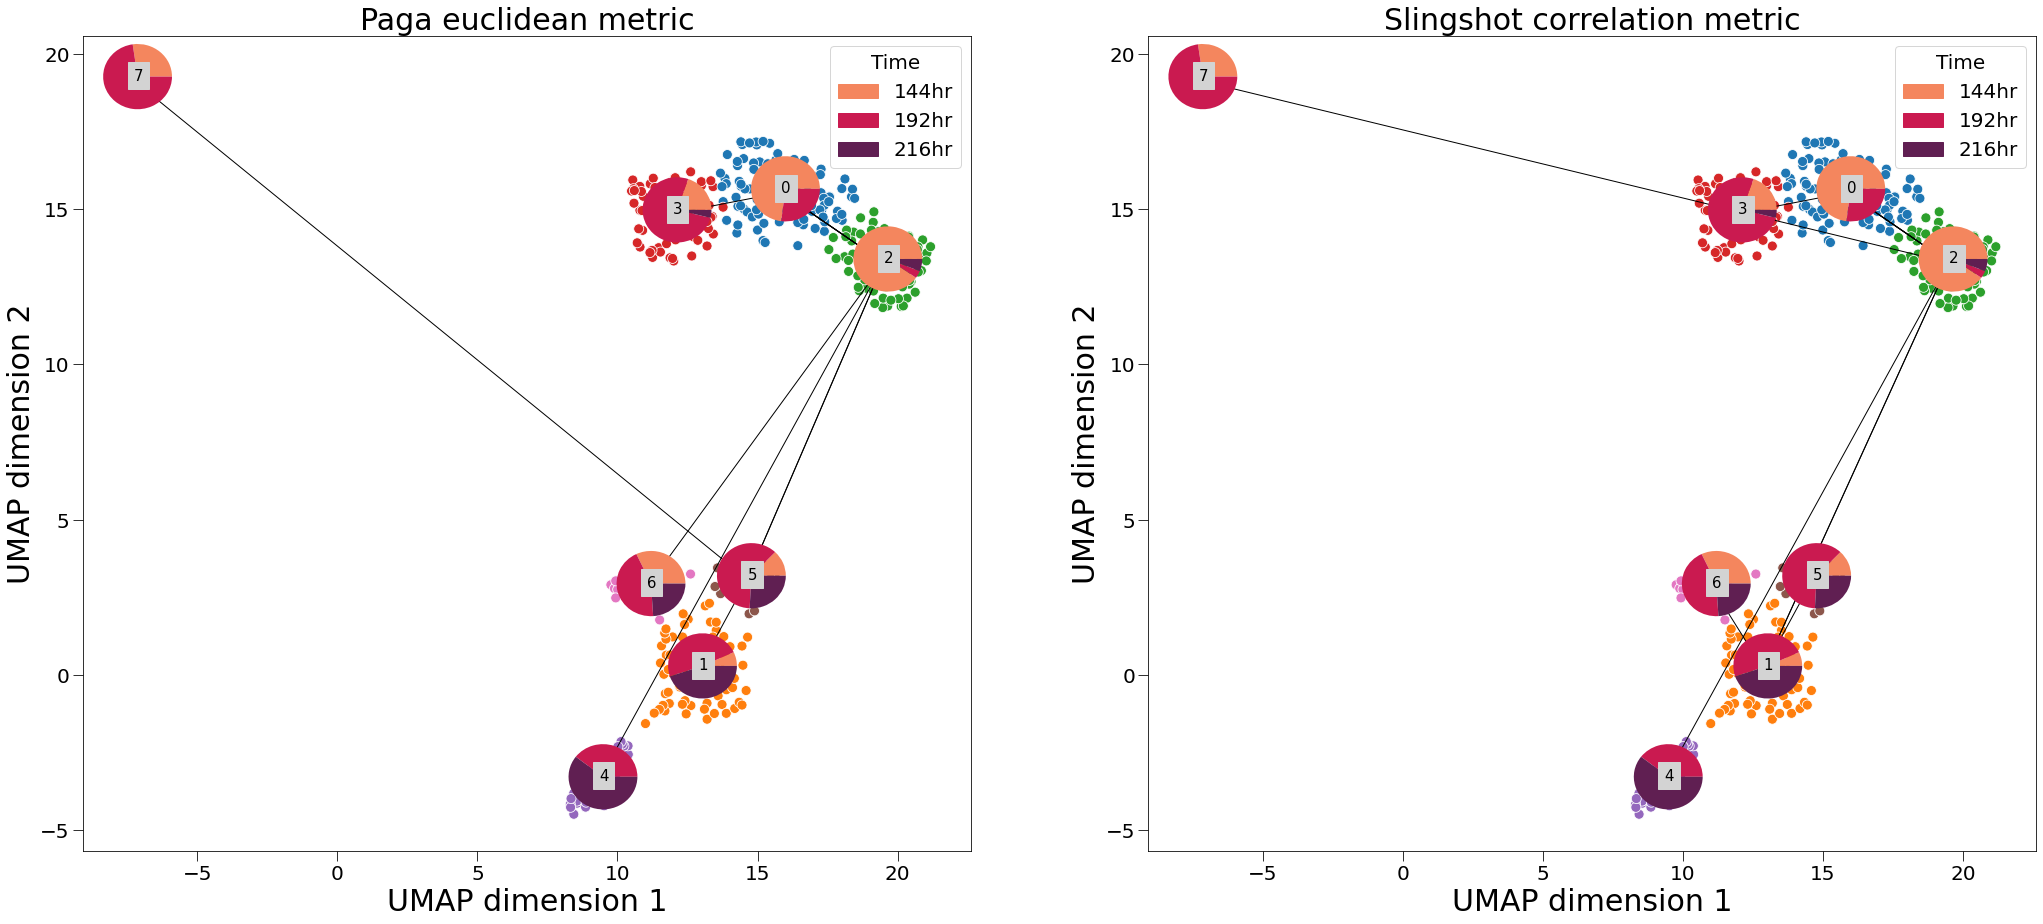

In [24]:
fig,ax = plt.subplots(1,2,figsize=[35,15])

# Plots
weight = adata.uns["paga"]["connectivities"].todense()
sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],hue=adata.obs["leiden"],s=100,ax=ax[0])
for lineage in model.lineages:
    for j in range(len(lineage.clusters)-1):
        x1,y1=adata[adata.obs["leiden"]==str(lineage.clusters[j])].obsm["X_umap"].mean(axis=0)
        x2,y2=adata[adata.obs["leiden"]==str(lineage.clusters[j+1])].obsm["X_umap"].mean(axis=0)
        
        ax[0].plot([x1,x2],[y1,y2],linewidth=1,color="black")
sctplot.plot_base(ax[0],title="Paga euclidean metric",labels=["UMAP dimension 1","UMAP dimension 2"])
sctplot.plot_scatter_pies(ax[0],adata,"X_umap","leiden","Time")
sctplot.plot_scatter_labels(ax[0],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)

# Plots
weight = adata.uns["paga"]["connectivities_tree"].todense()
sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],hue=adata.obs["leiden"],s=100,ax=ax[1])
for lineage in model2.lineages:
    for j in range(len(lineage.clusters)-1):
        x1,y1=adata[adata.obs["leiden"]==str(lineage.clusters[j])].obsm["X_umap"].mean(axis=0)
        x2,y2=adata[adata.obs["leiden"]==str(lineage.clusters[j+1])].obsm["X_umap"].mean(axis=0)
        
        ax[1].plot([x1,x2],[y1,y2],linewidth=1,color="black")
sctplot.plot_base(ax[1],title="Slingshot correlation metric",labels=["UMAP dimension 1","UMAP dimension 2"])
sctplot.plot_scatter_pies(ax[1],adata,"X_umap","leiden","Time")
sctplot.plot_scatter_labels(ax[1],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)

fig.savefig(DIRECTORY+"Plots/Sorted/TR_Slingshot_UMAP.pdf",bbox_inches="tight",transparent=True)

# Times

In [25]:
adata = scp.read(DIRECTORY+"Results/QC.h5ad")

In [26]:
adatas = [scp.read(DIRECTORY+"Results/QC_"+stage+".h5ad") for stage in np.sort(adata.obs["Time"].unique())]

## Paga

We connect the clusters using the PAGA algorithm and show the time contribution to each clusters in a pie plot overlayed over the UMAP plot.

In [27]:
for time,adata in enumerate(adatas):
    scp.pp.neighbors(adata,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
    scp.tl.paga(adata,groups="leiden")

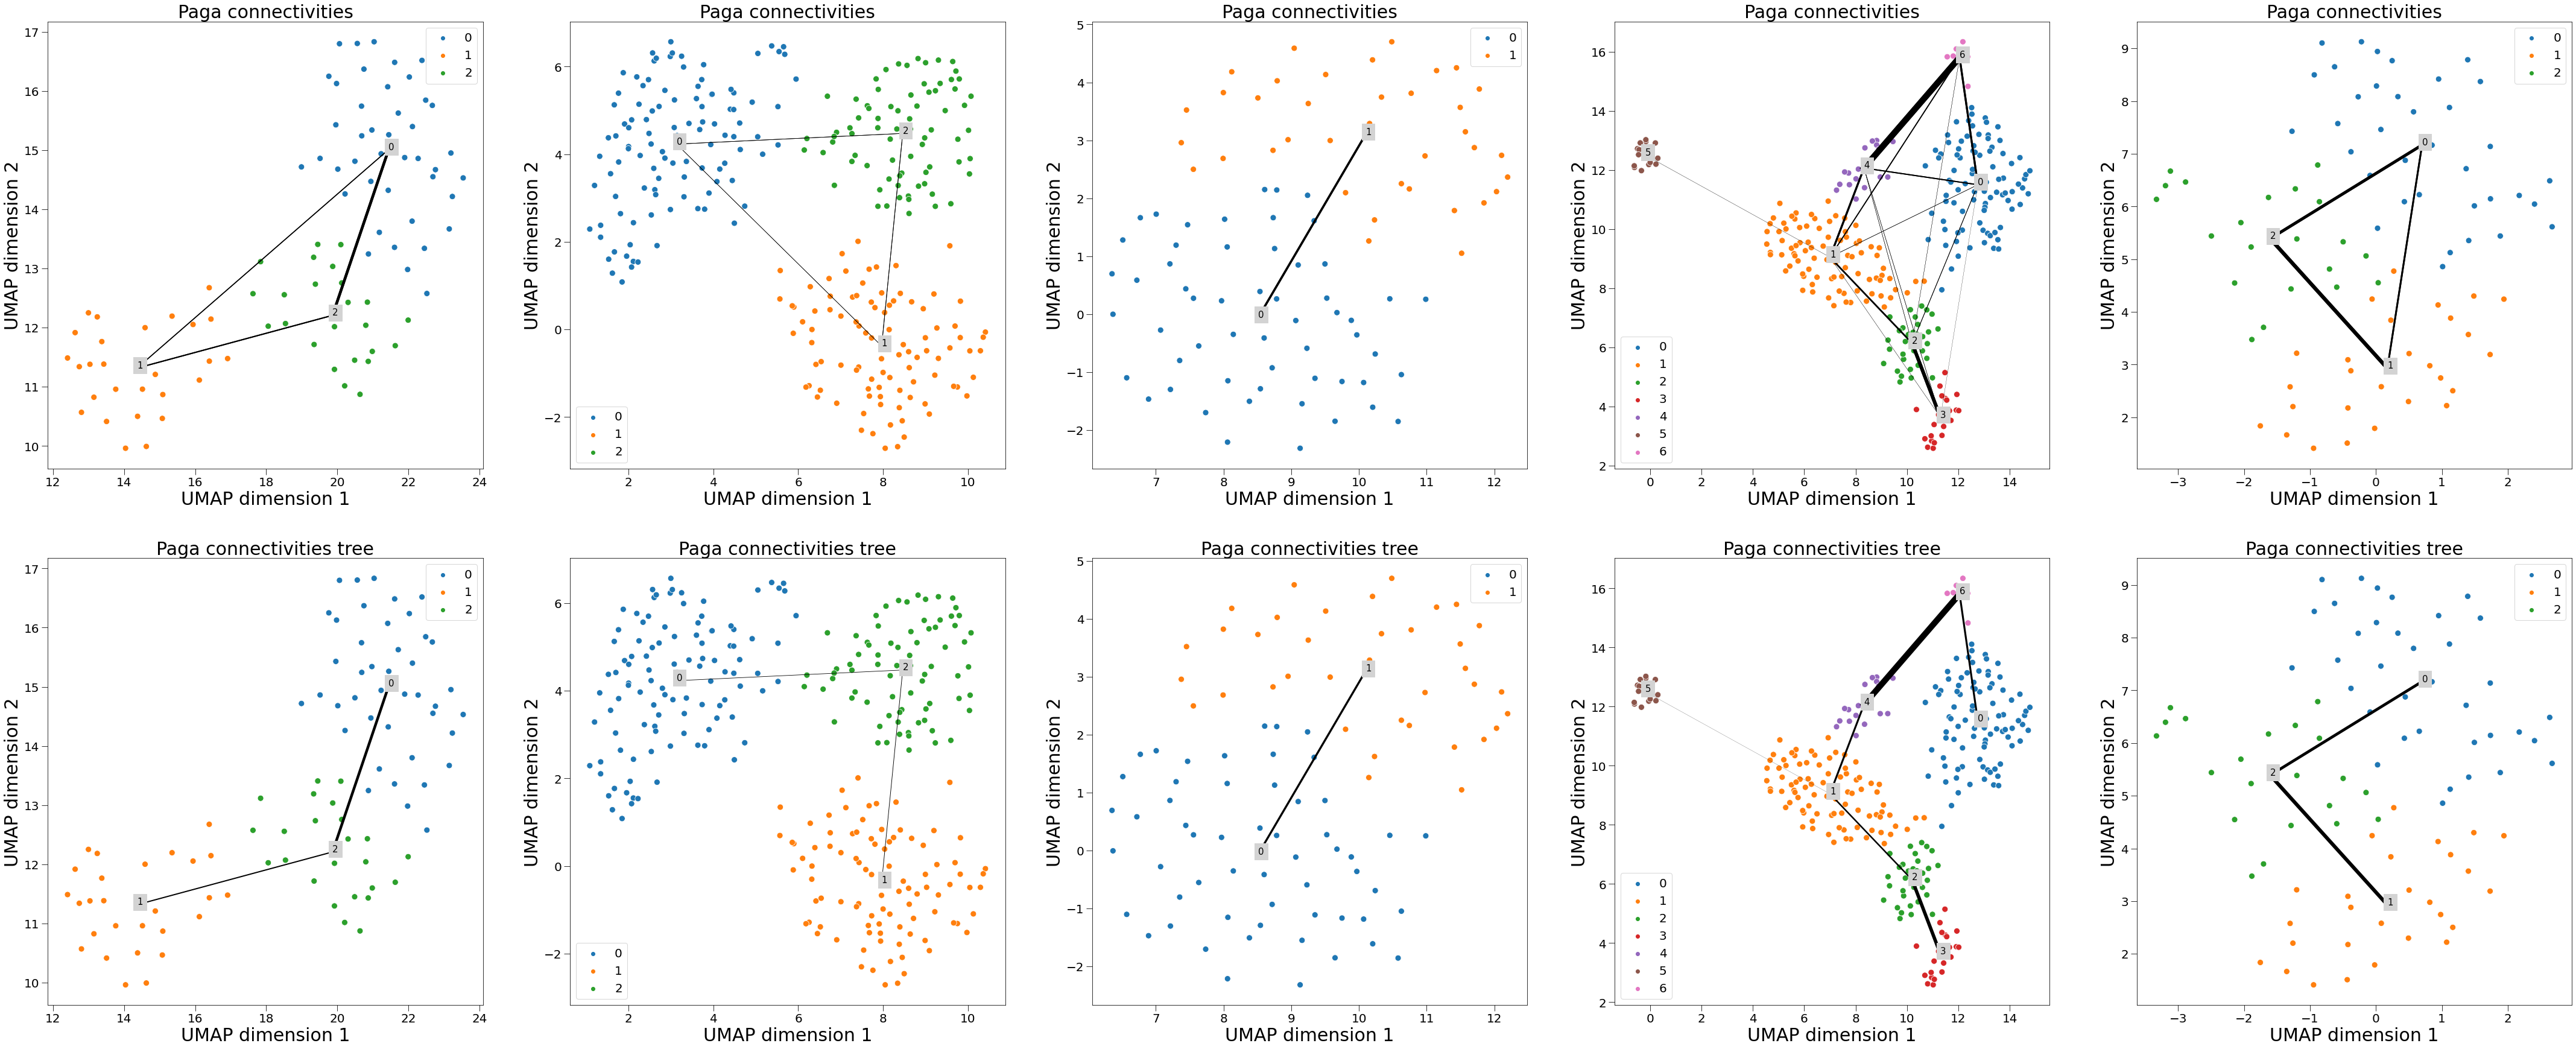

In [28]:
fig,ax = plt.subplots(2,5,figsize=[75,30])

for time,adata in enumerate(adatas):
    # Plots
    weight = adata.uns["paga"]["connectivities"].todense()
    sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],hue=adata.obs["leiden"],s=100,ax=ax[0,time])
    sctplot.plot_scatter_lines(ax[0,time],adata,"X_umap","leiden",weight)
    sctplot.plot_base(ax[0,time],title="Paga connectivities",labels=["UMAP dimension 1","UMAP dimension 2"])
    sctplot.plot_scatter_labels(ax[0,time],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)

    # Plots
    weight = adata.uns["paga"]["connectivities_tree"].todense()
    sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],hue=adata.obs["leiden"],s=100,ax=ax[1,time])
    sctplot.plot_scatter_lines(ax[1,time],adata,"X_umap","leiden",weight)
    sctplot.plot_base(ax[1,time],title="Paga connectivities tree",labels=["UMAP dimension 1","UMAP dimension 2"])
    sctplot.plot_scatter_labels(ax[1,time],adata,"X_umap","leiden",backgroundcolor="lightgrey",fontsize=15,zorder=10)

fig.savefig(DIRECTORY+"Plots/Times/TR_Paga_UMAP.pdf",bbox_inches="tight",transparent=True)

In [29]:
paga_robustness_list = []
for time,adata in enumerate(adatas):
    paga_robustness = np.zeros_like(adata.uns["paga"]["connectivities"].todense())

    for i in range(N_DOWNSAMPLE):
        adataDownsample = scttools.downsample(adata,P_DOWNSAMPLE,batch="leiden",seed=i)
        scp.pp.neighbors(adataDownsample,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
        scp.tl.paga(adataDownsample,groups="leiden")
        paga_robustness += adataDownsample.uns["paga"]["connectivities"].todense() > 0

    paga_robustness /= N_DOWNSAMPLE

    #Redo paga just in case
    scp.pp.neighbors(adata,n_pcs=PCA,knn=KNN_PAGA,metric=METRIC)
    scp.tl.paga(adata,groups="leiden")
    
    paga_robustness_list.append(paga_robustness)

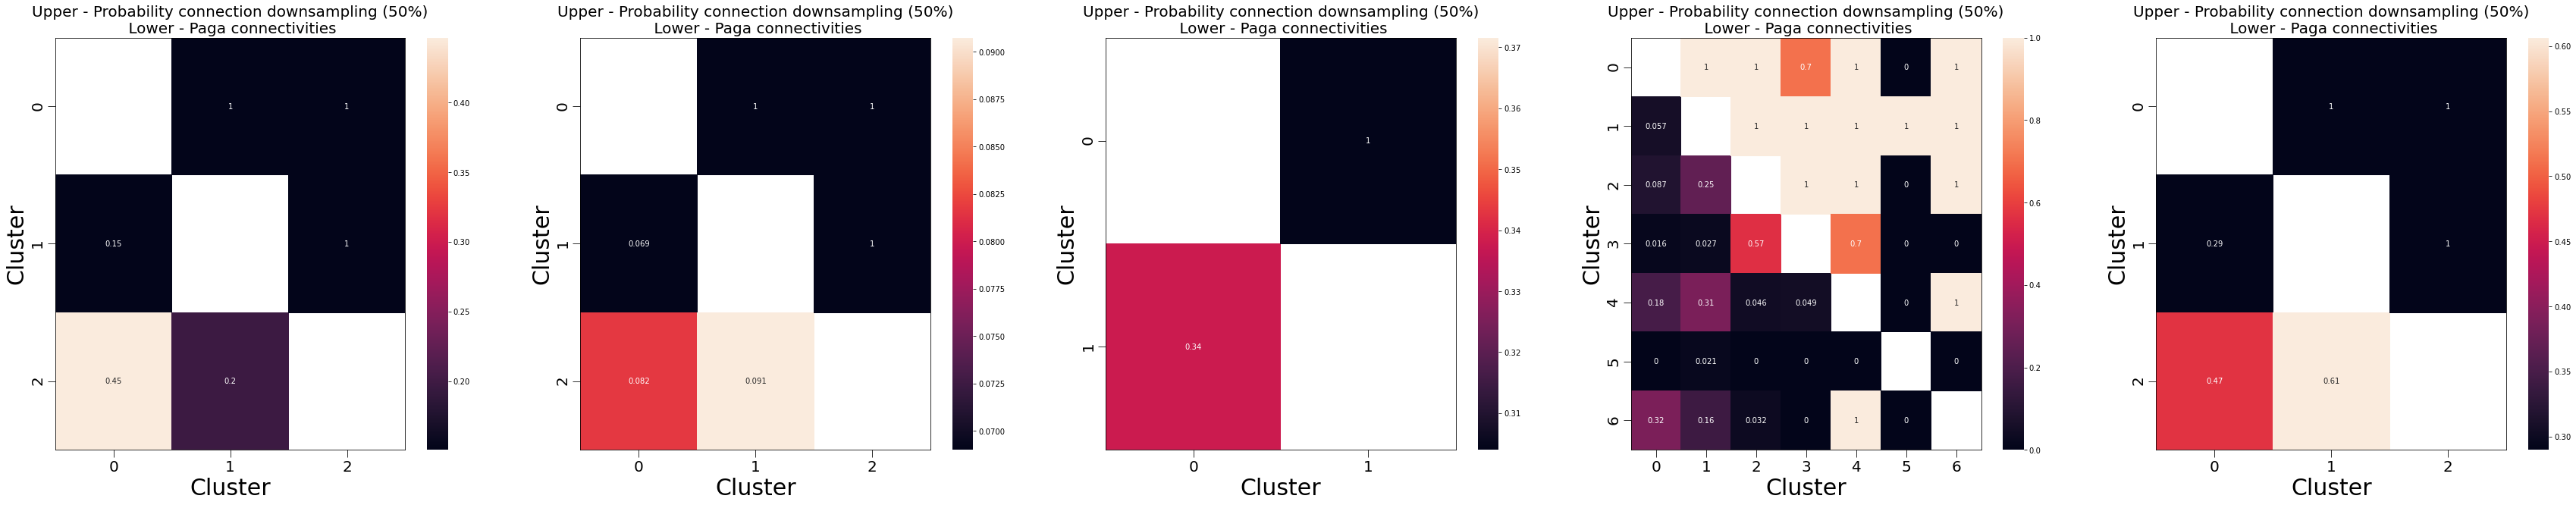

In [ ]:
fig,ax = plt.subplots(1,5,figsize=[60,10])

for time,adata in enumerate(adatas):
    paga_robustness = paga_robustness_list[time]
    paga = adata.uns["paga"]["connectivities"].todense()
    mask = np.zeros_like(paga)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(paga,annot=True,mask=mask,ax=ax[time])

    mask = np.zeros_like(paga)
    mask[np.tril_indices_from(mask)] = True
    paga_robustness[paga == 0] = 0
    sns.heatmap(paga_robustness,annot=True,mask=mask,ax=ax[time],cbar=False)

    sctplot.plot_base(ax[time],title="Upper - Probability connection downsampling (50%)\n Lower - Paga connectivities",title_size=20,labels=["Cluster","Cluster"]
                      ,xtick_labels=adata.obs["leiden"].cat.categories.values
                      ,ytick_labels=adata.obs["leiden"].cat.categories.values,
                     legend=False)

fig.savefig(DIRECTORY+"Plots/Times/TR_Paga_heatmap.pdf",bbox_inches="tight",transparent=True)